In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import networkx as nx

from utils.downloads import (
    Censo,
    Nivel,
    download_malha,
)

# Perímetros intercensitários (PICs)

## Explicação inicial e demonstração

A ideia é reproduzir a proposta abaixo, utilizando apenas a interseção entre os setores como fonte para o grafo.

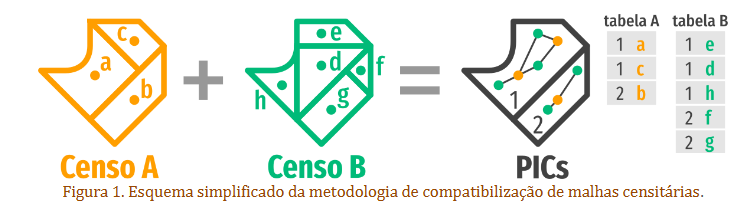

Para demonstrar o algoritmo, vamos utilizar um conjunto de geometrias de exemplo.

In [2]:
# Create geometries for set A
poly_a1 = Polygon([(0, 0), (2, 0), (2, 2), (0, 2)])
poly_a2 = Polygon([(2, 0), (4, 0), (4, 2), (2, 2)])
poly_a3 = Polygon([(4, 0), (6, 0), (6, 2), (4, 2)])
poly_a4 = Polygon([(0, 2), (6, 2), (6, 4), (0, 4)])

# Create geometries for set B
poly_b1 = Polygon([(0, 0), (3, 0), (3, 2), (0, 2)])
poly_b2 = Polygon([(3, 0), (6, 0), (6, 2), (3, 2)])
poly_b3 = Polygon([(0, 2), (3, 2), (3, 4), (0, 4)])
poly_b4 = Polygon([(3, 2), (6, 2), (6, 4), (3, 4)])

# Create GeoDataFrames
gdf_a = gpd.GeoDataFrame({'geometry': [poly_a1, poly_a2, poly_a3, poly_a4], 'id': [f'A{i}' for i in range(1,5)]})
gdf_b = gpd.GeoDataFrame({'geometry': [poly_b1, poly_b2, poly_b3, poly_b4], 'id': [f'B{i}' for i in range(1,5)]})

<Axes: >

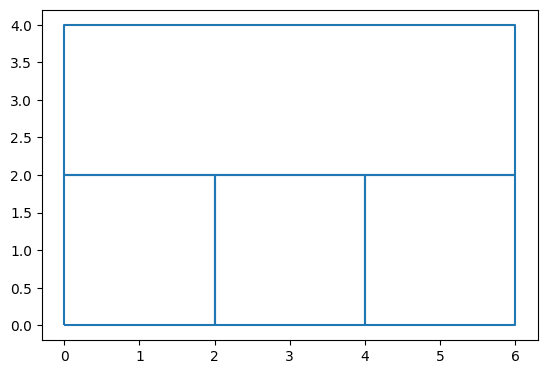

In [3]:
gdf_a.boundary.plot()

<Axes: >

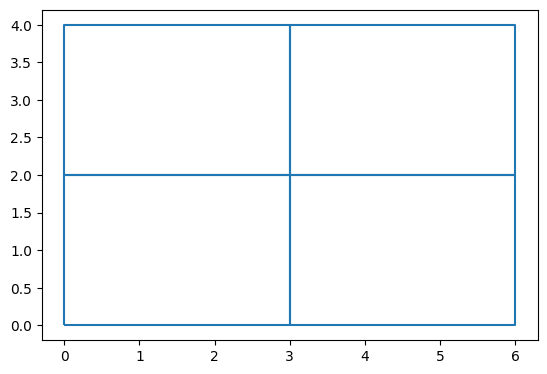

In [4]:
gdf_b.boundary.plot()

Nesse caso, o resultado desejado é um conjunto de dois retângulos, um de (0,0) a (6,2), e outro de (0,2) a (6,4).

Primeiro, precisamos encontrar as interseções entre as geometrias dos dataframes diferentes.

In [5]:
intersections = gpd.overlay(gdf_a, gdf_b, how='intersection', keep_geom_type=True)
intersections = intersections.reset_index()
intersections

,index,id_1,id_2,geometry
0,0,A1,B1,"POLYGON ((0.00000 0.00000, 0.00000 2.00000, 2...."
1,1,A2,B1,"POLYGON ((2.00000 0.00000, 2.00000 2.00000, 3...."
2,2,A2,B2,"POLYGON ((3.00000 0.00000, 3.00000 2.00000, 4...."
3,3,A3,B2,"POLYGON ((4.00000 0.00000, 4.00000 2.00000, 6...."
4,4,A4,B3,"POLYGON ((0.00000 2.00000, 0.00000 4.00000, 3...."
5,5,A4,B4,"POLYGON ((3.00000 2.00000, 3.00000 4.00000, 6...."


<Axes: >

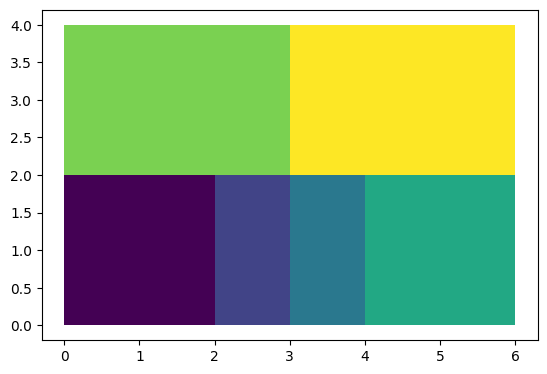

In [6]:
intersections.plot(column='index')

Agora, utilizamos as interseções encontradas para gerar os grafos de relação.

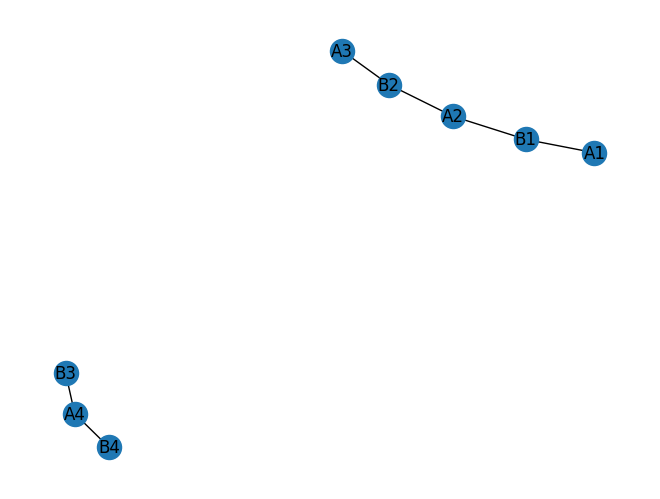

In [7]:
# Generate graph from the DataFrame
G = nx.from_pandas_edgelist(intersections[['id_1', 'id_2']], 'id_1', 'id_2')
nx.draw(G, with_labels=True)

Então, utilizamos os conjuntos de nós conectados para criar um novo dataframe.

In [8]:
connected_components = list(nx.connected_components(G))
rl_df = pd.DataFrame({'set': connected_components})
rl_df

,set
0,"{A1, A2, A3, B1, B2}"
1,"{B4, B3, A4}"


Para simplificar, vamos utilizar uma coluna de identificador numérico baseada no index.

In [9]:
rl_df = rl_df.reset_index()
rl_df['index'] = rl_df['index'] + 1
rl_df = rl_df.rename(columns={'index': 'pics'})
rl_df

,pics,set
0,1,"{A1, A2, A3, B1, B2}"
1,2,"{B4, B3, A4}"


Por último, vamos gerar um registro para cada item do conjunto de nós, de modo que este dataset se torna uma tabela associativa entre geometrias iniciais e "PICs".

In [10]:
rl_df = rl_df.explode('set')
rl_df = rl_df.rename(columns={'set':'item'})
rl_df

,pics,item
0,1,A1
0,1,A2
0,1,A3
0,1,B1
0,1,B2
1,2,B4
1,2,B3
1,2,A4


Finalmente, agregamos o identificador do PIC no dataframe de interseções.

In [11]:
intersections = intersections.merge(rl_df, how='left', left_on='id_1', right_on='item')
intersections

,index,id_1,id_2,geometry,pics,item
0,0,A1,B1,"POLYGON ((0.00000 0.00000, 0.00000 2.00000, 2....",1,A1
1,1,A2,B1,"POLYGON ((2.00000 0.00000, 2.00000 2.00000, 3....",1,A2
2,2,A2,B2,"POLYGON ((3.00000 0.00000, 3.00000 2.00000, 4....",1,A2
3,3,A3,B2,"POLYGON ((4.00000 0.00000, 4.00000 2.00000, 6....",1,A3
4,4,A4,B3,"POLYGON ((0.00000 2.00000, 0.00000 4.00000, 3....",2,A4
5,5,A4,B4,"POLYGON ((3.00000 2.00000, 3.00000 4.00000, 6....",2,A4


<Axes: >

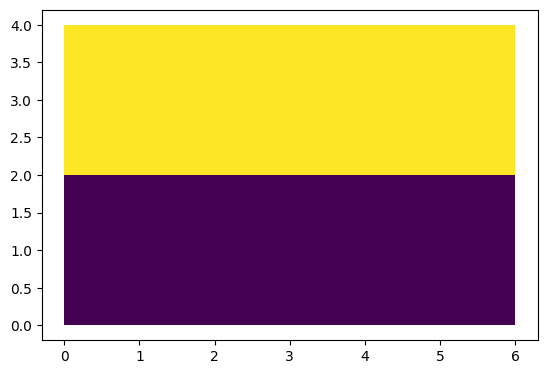

In [12]:
intersections.plot(column='pics')

E geramos um dataset final, apenas com o identificador dos PICs e as respectivas geometrias.

In [13]:
final_gdf = intersections[['pics', 'geometry']].dissolve('pics')
final_gdf = final_gdf.reset_index()
final_gdf

,pics,geometry
0,1,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 4...."
1,2,"POLYGON ((0.00000 4.00000, 3.00000 4.00000, 6...."


<Axes: >

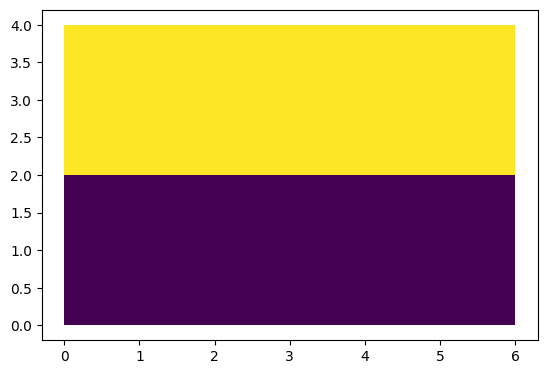

In [14]:
final_gdf.plot('pics')

## Generalização em uma função

In [15]:
def minimum_intergeometry_boundaries_relations(df:gpd.GeoDataFrame, other:gpd.GeoDataFrame, df_id_col:str=None, other_id_col:str=None, buffer:float=0) -> gpd.GeoDataFrame:
    if df_id_col == None:
        df = df.reset_index().copy()
        df_id_col = df.columns[0]
    if other_id_col == None:
        other = other.reset_index().copy()
        other_id_col = other.columns[0]

    original_df_id_col = df_id_col
    original_other_id_col = other_id_col
    if df_id_col == other_id_col:
        original_df_id_col = df_id_col
        df_id_col = df_id_col + '_1'
        original_other_id_col = other_id_col
        other_id_col = other_id_col + '_2'
    adjusted_df = df.copy()
    if buffer != 0:
        adjusted_df['geometry'] = df.buffer(buffer)
    
    intersections = gpd.overlay(adjusted_df, other, how='intersection', keep_geom_type=True)
    G = nx.from_pandas_edgelist(intersections[[df_id_col, other_id_col]], df_id_col, other_id_col)
    connected_components = list(nx.connected_components(G))
    rl_df = pd.DataFrame({'set': connected_components})
    rl_df = rl_df.reset_index()
    rl_df['index'] = rl_df['index'] + 1
    rl_df = rl_df.rename(columns={'index': 'pics'})
    rl_df = rl_df.explode('set')
    rl_df = rl_df.rename(columns={'set':'item'})
    return rl_df

In [16]:
def minimum_intergeometry_boundaries(df:gpd.GeoDataFrame, other:gpd.GeoDataFrame, df_id_col:str=None, other_id_col:str=None, buffer:float=0) -> gpd.GeoDataFrame:
    original_df_id_col = df_id_col
    original_other_id_col = other_id_col
    rl_df = minimum_intergeometry_boundaries_relations(df, other, df_id_col, other_id_col, buffer)
    
    final_gdf = df.merge(rl_df, how='left', left_on=original_df_id_col, right_on='item')
    final_gdf = final_gdf[['pics', 'geometry']].dissolve('pics')
    final_gdf = final_gdf.reset_index()
    return final_gdf

In [17]:
minimum_intergeometry_boundaries(gdf_a, gdf_b, 'id', 'id')

,pics,geometry
0,1,"POLYGON ((0.00000 0.00000, 0.00000 2.00000, 2...."
1,2,"POLYGON ((0.00000 2.00000, 6.00000 2.00000, 6...."


<Axes: >

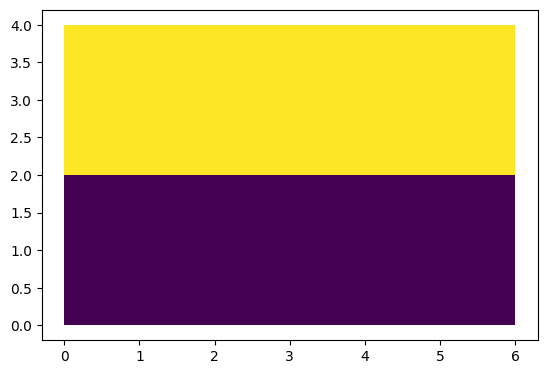

In [18]:
minimum_intergeometry_boundaries(gdf_a, gdf_b, 'id', 'id').plot(column='pics')

# Aplicando aos censos de 2010 e 2022

## Carregando os dados necessários

Para facilitar o desenvolvimento posterior, vamos concentrar os downloads e carregamentos iniciais nesta seção.

### Setores censitários de 2022

In [19]:
%%time
setores22 = download_malha(Censo.CENSO_2022, Nivel.SETORES)
setores22 = setores22[setores22['CD_MUN'] == '3550308']
setores22 = setores22.to_crs(epsg=31983)
setores22.sample(3)

CPU times: user 1min 4s, sys: 824 ms, total: 1min 5s
Wall time: 1min 5s


,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
91472,355030890000393P,0.005924,3,Sudeste,35,São Paulo,3550308,São Paulo,355030890,Vila Mariana,...,3550308,São Paulo/SP,158,100,100,0,1.975000,20.000000,80,"POLYGON ((332657.865 7391232.866, 332655.309 7..."
73287,355030830000252P,0.008247,3,Sudeste,35,São Paulo,3550308,São Paulo,355030830,Grajaú,...,3550308,São Paulo/SP,127,60,60,0,2.396226,13.207547,53,"POLYGON ((326964.761 7373177.012, 326939.385 7..."
80005,355030846000580P,0.006164,3,Sudeste,35,São Paulo,3550308,São Paulo,355030846,Jardim São Luís,...,3550308,São Paulo/SP,291,97,97,0,3.031250,19.791667,96,"POLYGON ((321442.229 7382808.227, 321435.731 7..."


### Setores censitários de 2010

In [20]:
setores10 = download_malha(Censo.CENSO_2010, Nivel.SETORES)
setores10 = setores10[setores10['CD_GEOCODM'] == '3550308']
setores10 = setores10.to_crs(epsg=31983)
setores10.sample(3)

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
45348,110930.0,355030816000053,URBANO,35503081600,None,355030816,CAMPO GRANDE,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,45349,"POLYGON ((328427.805 7379436.045, 328411.752 7..."
53616,119110.0,355030849000108,URBANO,35503084900,None,355030849,LIBERDADE,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,53617,"POLYGON ((333140.674 7393523.856, 333083.237 7..."
52817,120533.0,355030859000039,URBANO,35503085900,None,355030859,PENHA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,52818,"POLYGON ((343814.042 7398108.263, 343818.936 7..."


## Utilizando um distrito como exemplo

In [21]:
sample_dist = setores22['CD_DIST'].drop_duplicates().sample(1).iloc[0]
sample_dist

'355030842'

In [22]:
setores22_filtered = setores22[setores22['CD_DIST']==sample_dist].copy()
setores10_filtered = setores10[setores10['CD_GEOCODD']==sample_dist].copy()

Para mitigar possíveis problemas na definição dos setores censitários, vamos utilizar um buffer negativo de 10 metros.

In [23]:
pics = minimum_intergeometry_boundaries(setores22_filtered, setores10_filtered, 'CD_SETOR', 'CD_GEOCODI', buffer=-10)
pics

,pics,geometry
0,1,"POLYGON ((322639.146 7405851.909, 322625.248 7..."
1,2,"POLYGON ((322420.320 7406540.947, 322316.227 7..."
2,3,"POLYGON ((323146.319 7405833.541, 323147.256 7..."
3,4,"POLYGON ((323165.550 7405220.179, 323137.514 7..."
4,5,"POLYGON ((323012.218 7405106.137, 322917.717 7..."
...,...,...
98,99,"POLYGON ((324281.328 7404840.153, 324289.943 7..."
99,100,"POLYGON ((321669.733 7404820.660, 321681.901 7..."
100,101,"POLYGON ((323152.828 7405419.832, 323162.639 7..."
101,102,"POLYGON ((322980.018 7404733.198, 322979.717 7..."


<Axes: >

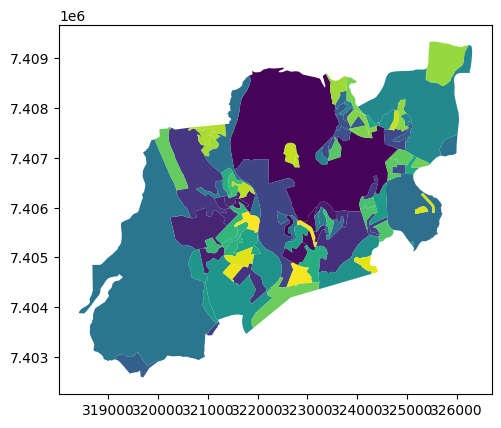

In [24]:
pics.plot(column='pics')

Vamos comparar a quantidade de setores censitários nos anos de 2010 e 2022 e a quantidade de PICs gerados pelo algoritmo.

In [25]:
qtd10 = setores10_filtered.shape[0]
qtd22 = setores22_filtered.shape[0]
qtdpics = pics.shape[0]

pd.DataFrame({'Tabela': ['Censo 2010', 'Censo 2022', 'PICs'], 'Qtd geometrias': [qtd10, qtd22, qtdpics]})

,Tabela,Qtd geometrias
0,Censo 2010,290
1,Censo 2022,590
2,PICs,103


Nota-se que ocorre uma perda de granularidade considerável, mesmo em relação ao Censo mais antigo. De todo modo, ainda existe um quantidade razoável de geometrias dendro de um determinado distrito, enquanto se elimina o erro estatístico relacionado à interpolação.